In [3]:
import pandas as pd
import numpy as np
import psycopg2
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# Database connection parameters
db_name = 'factihealth'   # Database name
db_user = 'fh_user'  # Username
db_password = 'Facti@874'  # Password
db_host = 'redshift-cluster-factihealth.cuzgotkwtow6.ap-south-1.redshift.amazonaws.com'  # Cluster endpoint
db_port = 5439  # Port
# Connect to the database
try:
    conn = psycopg2.connect(
        dbname=db_name,
        user=db_user,
        password=db_password,
        host=db_host,
        port=db_port
    )
    print("Connected to the database successfully")
    # Create a cursor object
    cur = conn.cursor()
    # Execute a query
    cur.execute('''select * from 
(
select 
distinct b.*,
        --TO_DATE(REPLACE(REPLACE(b.edadmittime, '2130', '2024'),'2129', '2024'),'YYYY-MM-DD') AS edadmit_time
        TO_DATE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(b.edadmittime, '2115', '2024'),'2116', '2024'),'2117', '2024'),'2118', '2024'),'2119', '2024'),'05-2024','03-2024'),'04-2024','03-2024'),'YYYY-MM-DD') AS edadmit_time
from 
    factihealth.mimic.ecg_model_dataset a
inner join 
    factihealth.mimic.mortality_data b on a.subject_id=b.subject_id
where date_part(year,edadmittime) in (2115,2116,2117,2118,2119,2126,2127,2128,2129, 2130)
and date_part(year,ecgtime) in (2115,2116,2117,2118,2119,2126,2127,2128,2129, 2130)
and ecgtime between edadmittime and eddischargetime
order by ecgtime,a.subject_id
)
where edadmit_time between '2024-02-01' AND '2024-03-03';''')
    # Fetch the result
    rows = cur.fetchall()

    # Get the column names
    column_names = [desc[0] for desc in cur.description]

    # Create a DataFrame
    master_data = pd.DataFrame(rows, columns=column_names)

    print('Dataframe shape:', master_data.shape)
    # Fetch and print the result
except Exception as e:
    print(f"Database connection failed due to {e}")

Connected to the database successfully
Dataframe shape: (34, 29)


In [9]:
master_data.to_csv('Mortality_Data.csv')

In [2]:
# Database connection parameters
db_name = 'factihealth'   # Database name
db_user = 'fh_user'  # Username
db_password = 'Facti@874'  # Password
db_host = 'redshift-cluster-factihealth.cuzgotkwtow6.ap-south-1.redshift.amazonaws.com'  # Cluster endpoint
db_port = 5439  # Port
# Connect to the database
try:
    conn = psycopg2.connect(
        dbname=db_name,
        user=db_user,
        password=db_password,
        host=db_host,
        port=db_port
    )
    print("Connected to the database successfully")
    # Create a cursor object
    cur = conn.cursor()
    # Execute a query
    cur.execute("select * from factihealth.mimic.mortality_data")
    # Fetch the result
    rows = cur.fetchall()

    # Get the column names
    column_names = [desc[0] for desc in cur.description]

    # Create a DataFrame
    master_data = pd.DataFrame(rows, columns=column_names)

    print('Dataframe shape:', master_data.shape)
    # Fetch and print the result
except Exception as e:
    print(f"Database connection failed due to {e}")

Connected to the database successfully
Dataframe shape: (73181, 26)


In [3]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73181 entries, 0 to 73180
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             73181 non-null  int64  
 1   hadm_id                                73181 non-null  int64  
 2   age                                    73181 non-null  int64  
 3   age_bucket                             73181 non-null  object 
 4   gender                                 73181 non-null  object 
 5   ethnicity                              73181 non-null  object 
 6   ethnicity_combined                     73181 non-null  object 
 7   admission_type                         73181 non-null  object 
 8   admission_type_combined                73181 non-null  object 
 9   first_careunit                         73181 non-null  object 
 10  first_careunit_combined                73181 non-null  object 
 11  ic

In [4]:
data=master_data.copy()

In [5]:
data.drop(['mixed_venous_o2_sat','ph_dipstick','icu_los','age_bucket','ethnicity','admission_type','first_careunit'],axis = 1, inplace = True)

# Define condition
condition_1 = data['non_invasive_blood_pressure_diastolic'] > 200
# Replace values in 'non_invasive_blood_pressure_diastolic' column based on the condition
data.loc[condition_1, 'non_invasive_blood_pressure_diastolic'] = data.loc[condition_1, 'non_invasive_blood_pressure_mean']

data = data[(data['heart_rate_mean'] >= 0) & (data['heart_rate_mean'] <= 500)]
data = data[(data['respiratory_rate'] >= 0) & (data['respiratory_rate'] <= 100)]
data = data[(data['temperature_fahrenheit'] >= 0) & (data['temperature_fahrenheit'] <= 250)]
data = data[(data['admission_weight_lbs'] >= 0) & (data['admission_weight_lbs'] <= 1000)]
data = data[(data['o2_saturation_pulseoxymetry2'] >= 0) & (data['o2_saturation_pulseoxymetry2'] <= 100)]
data = data[(data['height_cm'] >= 0) & (data['height_cm'] <= 300)]

data.drop(['non_invasive_blood_pressure_mean'],axis = 1, inplace = True)

In [6]:
df = data.copy()
# Apply one-hot encoding to 'admission_type' and 'first_careunit'
df_encoded = pd.get_dummies(df, columns=['admission_type_combined', 'first_careunit_combined','ethnicity_combined','gender'])
df_encoded.head()

,subject_id,hadm_id,age,hospital_expire_flag,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,respiratory_rate,...,ethnicity_combined_ASIAN,ethnicity_combined_BLACK/AFRICAN,ethnicity_combined_HISPANIC OR LATINO,ethnicity_combined_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_combined_OTHER,ethnicity_combined_PORTUGUESE,ethnicity_combined_SOUTH AMERICAN,ethnicity_combined_WHITE,gender_F,gender_M
2,19564586,22461053,64,0,99.738095,3.428571,2.714286,6.000000,81.260870,19.023810,...,0,0,0,0,0,0,0,1,0,1
5,13233046,21010085,63,1,93.083333,4.000000,5.000000,6.000000,57.588235,18.250000,...,0,0,0,0,0,0,0,1,0,1
6,12775498,20678397,55,0,76.339326,3.518987,2.750000,5.872093,62.677316,21.472851,...,0,1,0,0,0,0,0,0,0,1
9,10582595,20690213,91,0,92.237500,3.441176,4.705882,5.823529,59.629032,16.075000,...,0,0,0,0,0,0,0,1,1,0
11,12775498,20678397,55,0,76.339326,3.518987,2.750000,5.872093,62.677316,21.472851,...,0,1,0,0,0,0,0,0,0,1


In [7]:
# calculating fill rate of each column
fill_rates = df_encoded.count() / len(df_encoded) * 100
fill_rates

subject_id                                                      100.000000
hadm_id                                                         100.000000
age                                                             100.000000
hospital_expire_flag                                            100.000000
heart_rate_mean                                                 100.000000
gcs_eye_opening                                                  99.966875
gcs_verbal_response                                              99.969635
gcs_motor_response                                               99.961354
non_invasive_blood_pressure_diastolic                            99.224314
respiratory_rate                                                100.000000
temperature_fahrenheit                                          100.000000
height_cm                                                       100.000000
admission_weight_lbs                                            100.000000
o2_saturation_pulseoxymet

In [8]:
mean_value = df_encoded['non_invasive_blood_pressure_diastolic'].mean()

# Replace NaNs in the column with the calculated mean value
df_encoded['non_invasive_blood_pressure_diastolic'].fillna(mean_value, inplace=True)
df_encoded['gcs_eye_opening'].fillna(0, inplace=True)
df_encoded['gcs_verbal_response'].fillna(0, inplace=True)
df_encoded['gcs_motor_response'].fillna(0, inplace=True)

In [9]:
nan_per_column = df_encoded.isnull().sum()
print("NaNs in each column:\n", nan_per_column)

NaNs in each column:
 subject_id                                                      0
hadm_id                                                         0
age                                                             0
hospital_expire_flag                                            0
heart_rate_mean                                                 0
gcs_eye_opening                                                 0
gcs_verbal_response                                             0
gcs_motor_response                                              0
non_invasive_blood_pressure_diastolic                           0
respiratory_rate                                                0
temperature_fahrenheit                                          0
height_cm                                                       0
admission_weight_lbs                                            0
o2_saturation_pulseoxymetry2                                    0
admission_type_combined_Elective                      

In [10]:
np.shape(df_encoded)

(36226, 33)

In [11]:
df_encoded.head()

,subject_id,hadm_id,age,hospital_expire_flag,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,respiratory_rate,...,ethnicity_combined_ASIAN,ethnicity_combined_BLACK/AFRICAN,ethnicity_combined_HISPANIC OR LATINO,ethnicity_combined_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_combined_OTHER,ethnicity_combined_PORTUGUESE,ethnicity_combined_SOUTH AMERICAN,ethnicity_combined_WHITE,gender_F,gender_M
2,19564586,22461053,64,0,99.738095,3.428571,2.714286,6.000000,81.260870,19.023810,...,0,0,0,0,0,0,0,1,0,1
5,13233046,21010085,63,1,93.083333,4.000000,5.000000,6.000000,57.588235,18.250000,...,0,0,0,0,0,0,0,1,0,1
6,12775498,20678397,55,0,76.339326,3.518987,2.750000,5.872093,62.677316,21.472851,...,0,1,0,0,0,0,0,0,0,1
9,10582595,20690213,91,0,92.237500,3.441176,4.705882,5.823529,59.629032,16.075000,...,0,0,0,0,0,0,0,1,1,0
11,12775498,20678397,55,0,76.339326,3.518987,2.750000,5.872093,62.677316,21.472851,...,0,1,0,0,0,0,0,0,0,1


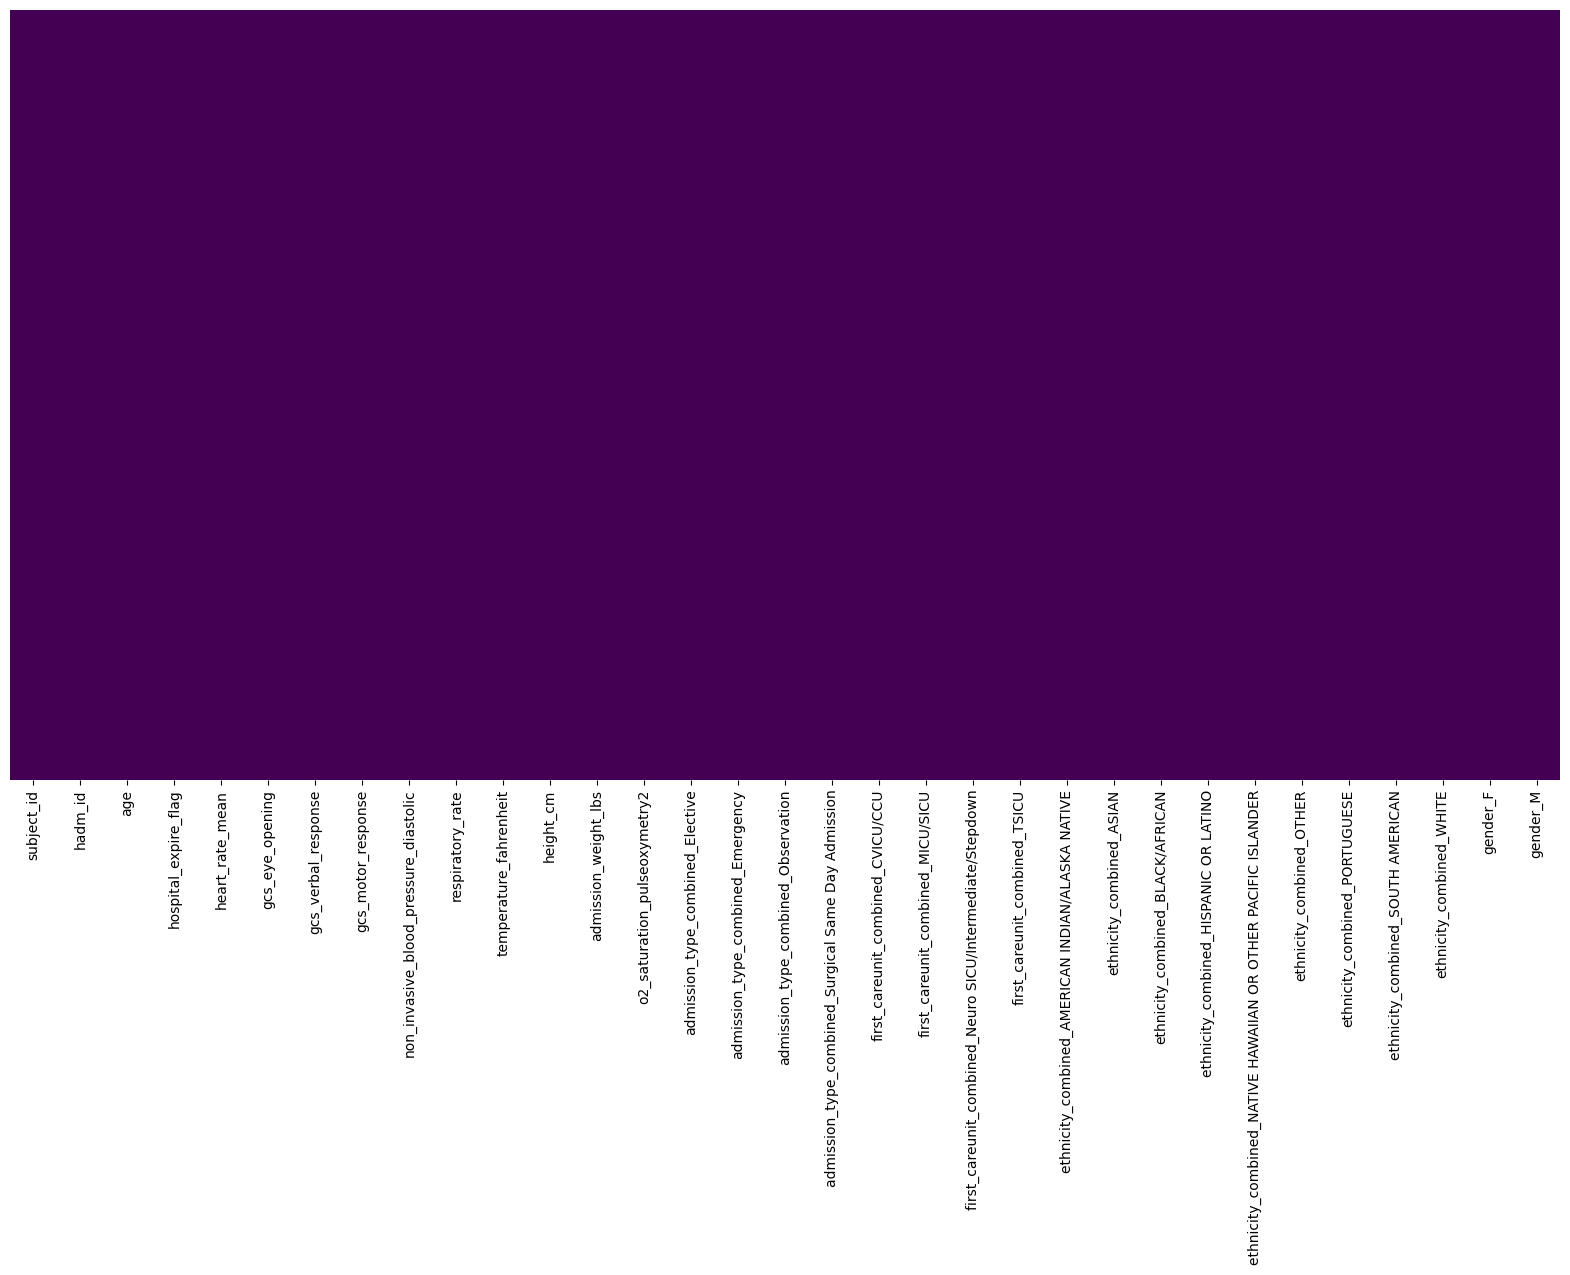

In [12]:
plt.figure(figsize=(20, 10)) 
sns.heatmap(df_encoded.isnull(), yticklabels = False, cbar = False, cmap='viridis')
plt.xticks(rotation=90)
plt.show()

In [13]:
df_encoded.drop(columns=['subject_id','hadm_id'],inplace = True)

In [14]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36226 entries, 2 to 73180
Data columns (total 31 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   age                                                           36226 non-null  int64  
 1   hospital_expire_flag                                          36226 non-null  int64  
 2   heart_rate_mean                                               36226 non-null  float64
 3   gcs_eye_opening                                               36226 non-null  float64
 4   gcs_verbal_response                                           36226 non-null  float64
 5   gcs_motor_response                                            36226 non-null  float64
 6   non_invasive_blood_pressure_diastolic                         36226 non-null  float64
 7   respiratory_rate                                              36226

In [15]:
df_encoded.head()

,age,hospital_expire_flag,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,respiratory_rate,temperature_fahrenheit,height_cm,...,ethnicity_combined_ASIAN,ethnicity_combined_BLACK/AFRICAN,ethnicity_combined_HISPANIC OR LATINO,ethnicity_combined_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_combined_OTHER,ethnicity_combined_PORTUGUESE,ethnicity_combined_SOUTH AMERICAN,ethnicity_combined_WHITE,gender_F,gender_M
2,64,0,99.738095,3.428571,2.714286,6.000000,81.260870,19.023810,99.300000,183.0,...,0,0,0,0,0,0,0,1,0,1
5,63,1,93.083333,4.000000,5.000000,6.000000,57.588235,18.250000,97.900001,175.0,...,0,0,0,0,0,0,0,1,0,1
6,55,0,76.339326,3.518987,2.750000,5.872093,62.677316,21.472851,98.913393,174.0,...,0,1,0,0,0,0,0,0,0,1
9,91,0,92.237500,3.441176,4.705882,5.823529,59.629032,16.075000,97.960714,163.0,...,0,0,0,0,0,0,0,1,1,0
11,55,0,76.339326,3.518987,2.750000,5.872093,62.677316,21.472851,98.913393,174.0,...,0,1,0,0,0,0,0,0,0,1


## Modelling

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [17]:
X = df_encoded.drop('hospital_expire_flag', axis=1)
y = df_encoded['hospital_expire_flag']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
y_pred = rf_classifier.predict(X_test)

In [33]:
probabilities = rf_classifier.predict_proba(X_test)

array([[1.  , 0.  ],
       [0.99, 0.01],
       [0.99, 0.01],
       ...,
       [0.97, 0.03],
       [0.91, 0.09],
       [0.95, 0.05]])

In [21]:
# Evaluating the Algorithm
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

[[6295   66]
 [ 332  553]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6361
           1       0.89      0.62      0.74       885

    accuracy                           0.95      7246
   macro avg       0.92      0.81      0.85      7246
weighted avg       0.94      0.95      0.94      7246

Accuracy: 0.9450731438034777


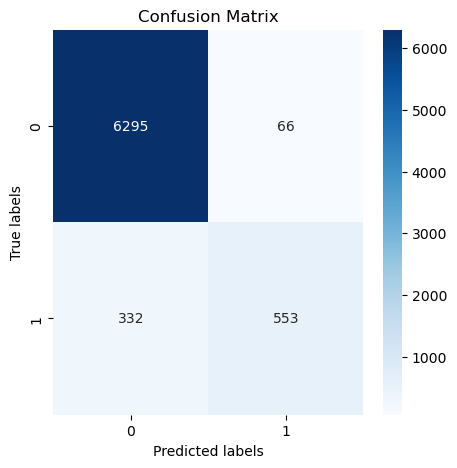

In [48]:
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
class_names = rf_classifier.classes_
probabilities_df = pd.DataFrame(probabilities, columns=['Y_0','Y_1'])
probabilities_df.head()

,Y_0,Y_1
0,1.00,0.00
1,0.99,0.01
2,0.99,0.01
3,0.86,0.14
4,0.92,0.08


In [39]:
pred_dataset_reset

,index,y_test,Y_pred
0,54032,0,0
1,6248,0,0
2,13565,0,0
3,37262,0,0
4,11923,0,0
...,...,...,...
7241,14085,0,0
7242,63026,0,0
7243,59611,0,0
7244,52038,0,0


In [41]:
pred_dataset_reset = y_test.reset_index()
pred_dataset_reset.rename(columns={'hospital_expire_flag': 'y_test'}, inplace=True)
pred_dataset_reset['Y_pred']=y_pred
pred_dataset_reset['Y_prob_1']=probabilities_df['Y_1']*100
pred_dataset_reset['Y_prob_0']=probabilities_df['Y_0']*100
pred_dataset_reset

,index,y_test,Y_pred,Y_prob_1,Y_prob_0
0,54032,0,0,0.0,100.0
1,6248,0,0,1.0,99.0
2,13565,0,0,1.0,99.0
3,37262,0,0,14.0,86.0
4,11923,0,0,8.0,92.0
...,...,...,...,...,...
7241,14085,0,0,6.0,94.0
7242,63026,0,0,29.0,71.0
7243,59611,0,0,3.0,97.0
7244,52038,0,0,9.0,91.0


In [42]:
df_reset = df.reset_index()
# Optionally, if you want to name the new column
df_reset.rename(columns={'index': 'index'}, inplace=True)

In [43]:
df_reset.head()

,index,subject_id,hadm_id,age,gender,ethnicity_combined,admission_type_combined,first_careunit_combined,hospital_expire_flag,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,respiratory_rate,temperature_fahrenheit,height_cm,admission_weight_lbs,o2_saturation_pulseoxymetry2
0,2,19564586,22461053,64,M,WHITE,Emergency,CVICU/CCU,0,99.738095,3.428571,2.714286,6.000000,81.260870,19.023810,99.300000,183.0,274.100006,95.761905
1,5,13233046,21010085,63,M,WHITE,Emergency,CVICU/CCU,1,93.083333,4.000000,5.000000,6.000000,57.588235,18.250000,97.900001,175.0,103.000000,93.944444
2,6,12775498,20678397,55,M,BLACK/AFRICAN,Emergency,CVICU/CCU,0,76.339326,3.518987,2.750000,5.872093,62.677316,21.472851,98.913393,174.0,246.850006,97.943820
3,9,10582595,20690213,91,F,WHITE,Emergency,TSICU,0,92.237500,3.441176,4.705882,5.823529,59.629032,16.075000,97.960714,163.0,119.500000,96.748428
4,11,12775498,20678397,55,M,BLACK/AFRICAN,Emergency,CVICU/CCU,0,76.339326,3.518987,2.750000,5.872093,62.677316,21.472851,98.913393,174.0,246.850006,97.943820


In [44]:
result = pd.merge(pred_dataset_reset,df_reset, on='index', how='inner')

In [45]:
result.drop(columns=['index'],inplace= True)
result.head()

,y_test,Y_pred,Y_prob_1,Y_prob_0,subject_id,hadm_id,age,gender,ethnicity_combined,admission_type_combined,...,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,respiratory_rate,temperature_fahrenheit,height_cm,admission_weight_lbs,o2_saturation_pulseoxymetry2
0,0,0,0.0,100.0,10653798,23023391,76,M,WHITE,Elective,...,92.818182,4.000000,5.000000,6.000000,73.103448,13.181818,98.561538,175.0,181.899994,96.890909
1,0,0,1.0,99.0,16490533,21366333,60,M,ASIAN,Emergency,...,104.777251,3.724138,4.555556,5.620690,81.733766,21.990521,98.316326,163.0,115.720001,95.270531
2,0,0,1.0,99.0,17558408,27473241,69,F,WHITE,Surgical Same Day Admission,...,72.461538,3.559633,3.376147,5.925926,65.854626,17.659044,98.298165,173.0,172.919998,96.913934
3,0,0,14.0,86.0,15191472,21529173,38,M,HISPANIC OR LATINO,Emergency,...,101.239130,3.666667,3.666667,4.333333,77.045455,22.326087,103.549999,170.0,178.600006,95.543478
4,0,0,8.0,92.0,18175636,26997492,91,F,WHITE,Emergency,...,70.243243,4.000000,5.000000,6.000000,47.303030,21.081081,98.449999,157.0,147.800003,96.764706


In [46]:
np.shape(result)

(7246, 22)

In [29]:
result.to_csv('results.csv',index=False)